## Perturbation of sequences
### Dataset: UniProt SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

613

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(19460488, 15)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.014662,0.000120,0.000159,0.009493,0.000217,0.975218,0.000026,0.000106,A0A8B1JQG7,Human,N,382,A,-0.000090,0.000090
1,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,N,1682,H,0.000000,0.000000
2,0.016292,0.000111,0.000143,0.008804,0.000225,0.974300,0.000025,0.000100,A0A8B1JQG7,Human,X,647,H,-0.001007,0.001007
3,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,Q,1912,T,0.000000,0.000000
4,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,V,1383,H,0.000000,0.000000


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

In [9]:
# plt.clf()
# plt.figure(figsize=(48, 16))
# plt.rcParams['xtick.labelsize'] = 24
# plt.rcParams['ytick.labelsize'] = 24
# sns.distplot(perturbed_output_df["Human_pred_diff"])
# plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.752989,-0.674093,40,0.000206
1,-0.674093,-0.595196,138,0.000709
2,-0.595196,-0.516300,428,0.002199
3,-0.516300,-0.437403,97,0.000498
4,-0.437403,-0.358507,333,0.001711
5,-0.358507,-0.279610,400,0.002055
6,-0.279610,-0.200713,354,0.001819
7,-0.200713,-0.121817,1694,0.008705
8,-0.121817,-0.042920,9219,0.047373
9,-0.042920,0.035976,19424214,99.813602


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 9305
Number of unique positions = 60
Unique positions = [469. 468. 467. 293. 303. 295. 309. 298. 292. 299. 307. 597. 301. 596.
 288. 109. 107. 294. 296. 302. 211. 466. 308. 300. 533. 584. 106. 470.
 316. 240. 314. 575. 313. 304. 310. 287. 586. 311. 315. 290. 326. 306.
 583. 297. 516. 305. 291. 598. 289. 312. 417. 258. 250. 318. 242. 319.
 317. 241. 285. 284.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_3255398/3825924755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
3170,0.729948,0.000211,0.000007,0.002718,0.067744,0.197221,0.002031,0.000121,A0A8B1JGY8,Human,D,982,H,-0.752989,0.752989,467.0,sarscov2-uniprot-aligned-multi
12213,0.724698,0.000215,0.000007,0.002843,0.065369,0.204720,0.002023,0.000124,A0A8B6RMZ9,Human,D,982,H,-0.745023,0.745023,467.0,sarscov2-uniprot-aligned-multi
15704,0.730549,0.000209,0.000007,0.002721,0.066958,0.197339,0.002096,0.000121,A0A8B6R9R3,Human,D,982,H,-0.741501,0.741501,467.0,sarscov2-uniprot-aligned-multi
9718,0.724309,0.000227,0.000007,0.002829,0.069360,0.200997,0.002140,0.000130,A0A7U3HJV4,Human,D,982,H,-0.736590,0.736590,467.0,sarscov2-uniprot-aligned-multi
12241,0.721581,0.000208,0.000007,0.002867,0.063637,0.209530,0.002048,0.000122,A0A8B1JLH2,Human,D,982,H,-0.734036,0.734036,467.0,sarscov2-uniprot-aligned-multi
16339,0.708632,0.000226,0.000009,0.003106,0.059837,0.226123,0.001933,0.000136,A0A8B6RS06,Human,D,982,H,-0.731072,0.731072,467.0,sarscov2-uniprot-aligned-multi
7769,0.737268,0.000207,0.000007,0.002592,0.070221,0.187474,0.002115,0.000117,A0A8B1KFH5,Human,D,982,H,-0.730722,0.730722,467.0,sarscov2-uniprot-aligned-multi
22639,0.708187,0.000228,0.000008,0.003261,0.062502,0.223688,0.001992,0.000133,A0A8B6R9G8,Human,D,982,H,-0.730620,0.730620,467.0,sarscov2-uniprot-aligned-multi
1382,0.731425,0.000208,0.000006,0.002624,0.069050,0.194543,0.002027,0.000117,A0A8B1JX34,Human,D,982,H,-0.726355,0.726355,467.0,sarscov2-uniprot-aligned-multi
16383,0.711132,0.000232,0.000008,0.002997,0.065497,0.217899,0.002100,0.000135,A0A8B1KG33,Human,D,982,H,-0.721789,0.721789,467.0,sarscov2-uniprot-aligned-multi


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_3255398/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
6878,0.140059,0.000194,0.000089,0.012897,0.002654,0.843656,0.000278,0.000174,A0A8B1JQG7,Human,S,984,H,-0.131651,0.131651,469.0,sarscov2-uniprot-aligned-multi,469.0_H
12836,0.131768,0.000201,0.000101,0.014153,0.002517,0.850805,0.000276,0.000179,A0A8B1JQG7,Human,I,983,H,-0.124502,0.124502,468.0,sarscov2-uniprot-aligned-multi,468.0_H
15508,0.298555,0.000390,0.000071,0.012706,0.012175,0.674678,0.001099,0.000325,A0A8B1JQG7,Human,D,982,H,-0.300629,0.300629,467.0,sarscov2-uniprot-aligned-multi,467.0_H
1046,0.083978,0.000068,0.000052,0.005961,0.000767,0.909037,0.000069,0.000068,A0A6M6IYS1,Human,L,632,X,0.139996,0.139996,293.0,sarscov2-uniprot-aligned-multi,293.0_X
1214,0.041413,0.000064,0.000048,0.004565,0.000360,0.953457,0.000028,0.000065,A0A6M6IYS1,Human,L,642,X,0.184417,0.184417,303.0,sarscov2-uniprot-aligned-multi,303.0_X


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,106.0_H,0.185386,106.0,H
1,106.0_X,0.128496,106.0,X
2,107.0_X,0.103974,107.0,X
3,109.0_H,0.102957,109.0,H
4,211.0_H,0.130328,211.0,H


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
80,467.0_H,0.469867,467.0,H
84,469.0_H,0.326265,469.0,H
82,468.0_H,0.319288,468.0,H
90,533.0_W,0.297365,533.0,W
95,596.0_H,0.274225,596.0,H
86,470.0_H,0.271495,470.0,H
92,583.0_H,0.231498,583.0,H
46,308.0_H,0.215541,308.0,H
0,106.0_H,0.185386,106.0,H
61,308.0_W,0.182393,308.0,W


<Figure size 432x288 with 0 Axes>

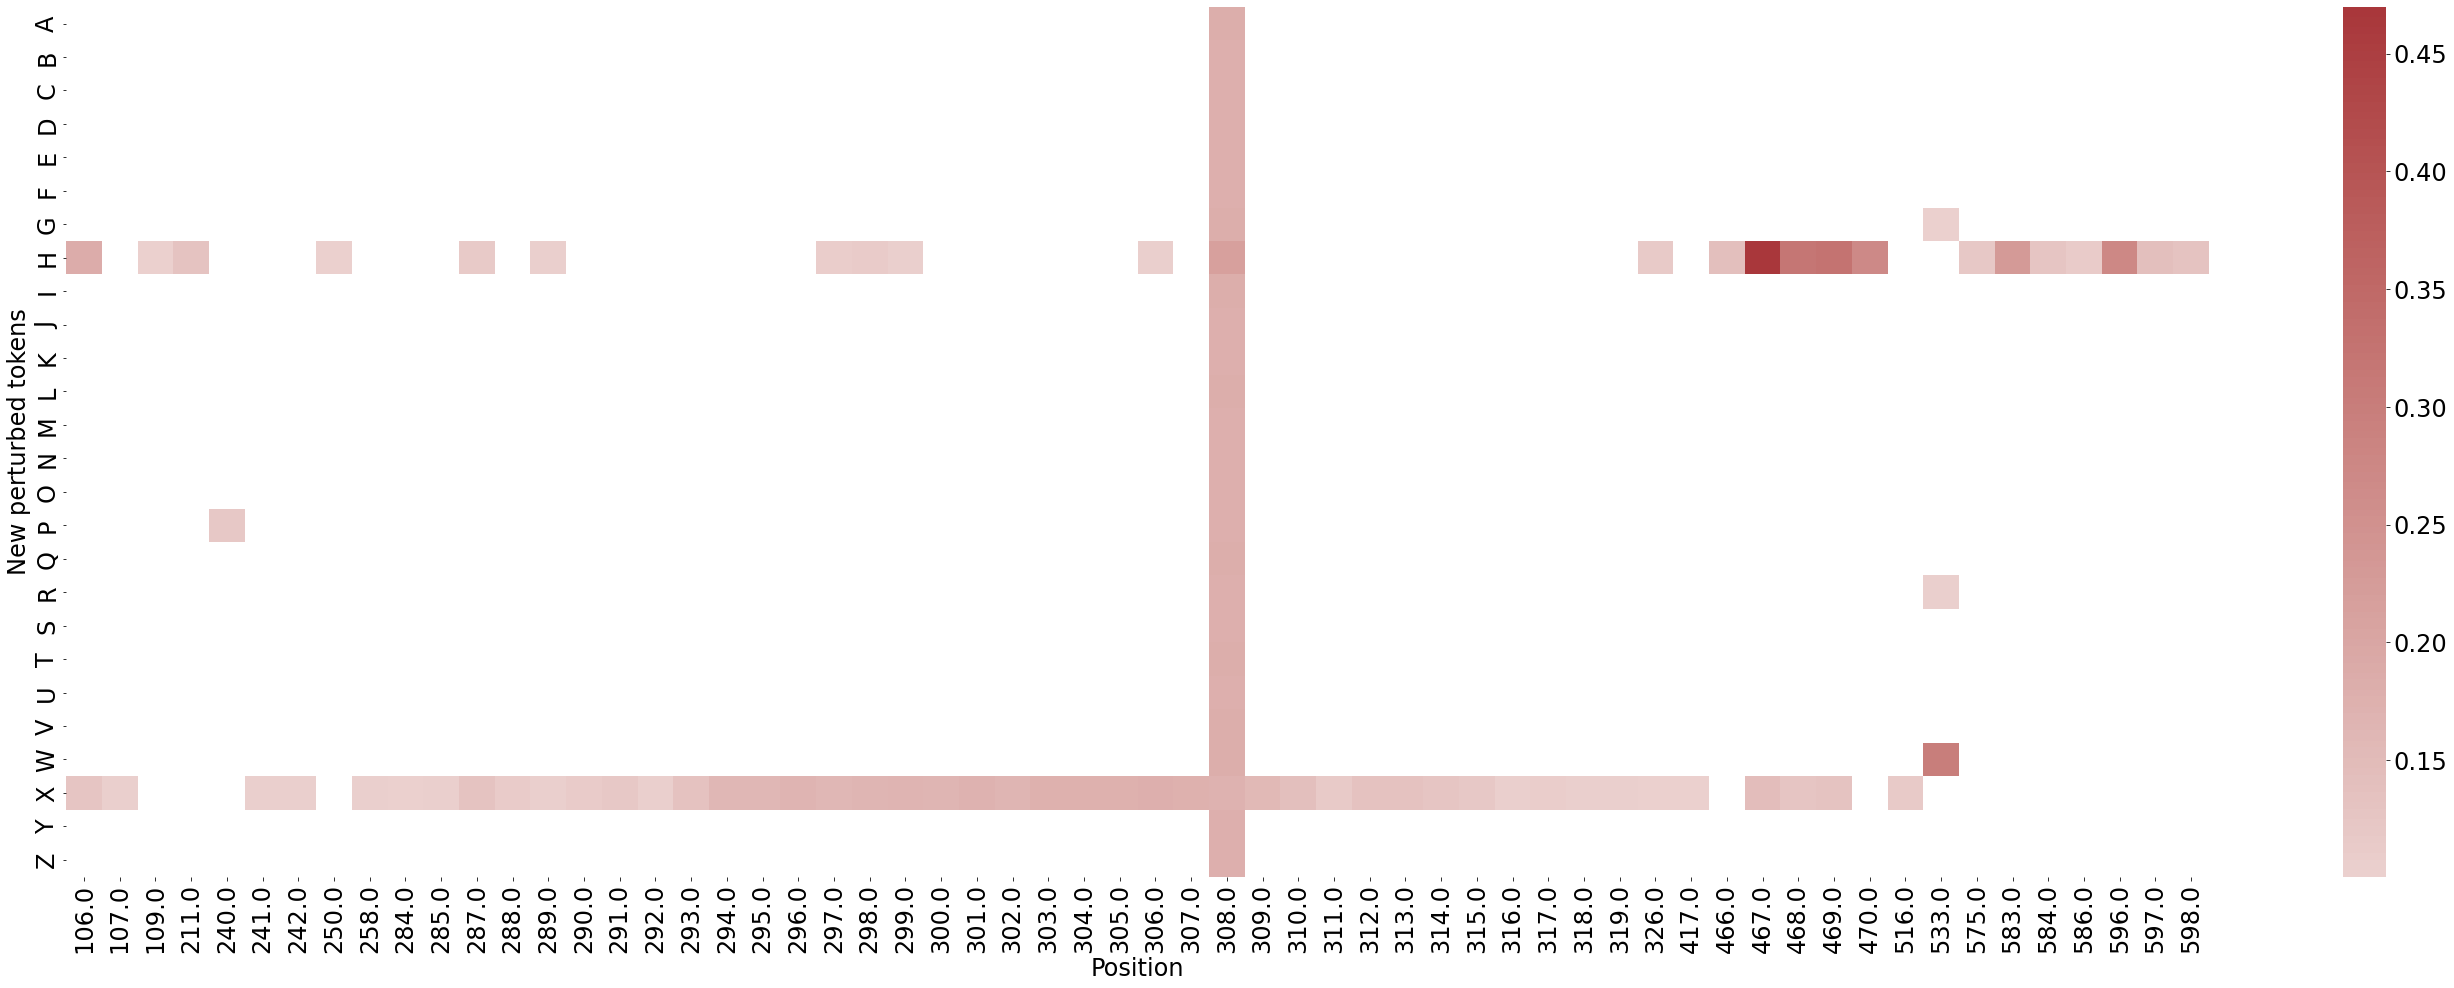

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
106.0    0.156941
107.0    0.103974
109.0    0.102957
211.0    0.130328
240.0    0.120599
241.0    0.103985
242.0    0.105676
250.0    0.100549
258.0    0.103758
284.0    0.100916
285.0    0.105620
287.0    0.123983
288.0    0.110846
289.0    0.103774
290.0    0.111059
291.0    0.121929
292.0    0.107019
293.0    0.136140
294.0    0.162181
295.0    0.158491
296.0    0.169424
297.0    0.134970
298.0    0.138365
299.0    0.136211
300.0    0.165159
301.0    0.172398
302.0    0.163077
303.0    0.174796
304.0    0.175312
305.0    0.176983
306.0    0.141603
307.0    0.174189
308.0    0.180785
309.0    0.156983
310.0    0.142740
311.0    0.115374
312.0    0.132549
313.0    0.132774
314.0    0.126108
315.0    0.120004
316.0    0.107331
317.0    0.108986
318.0    0.104544
319.0    0.106700
326.0    0.109393
417.0    0.101370
466.0    0.143531
467.0    0.308092
468.0    0.223904
469.0    0.227946
470.0    0.271495
516.0    0.115258
533.0    0.168642
575.0    0.120226
583.0    0.2

<Figure size 432x288 with 0 Axes>

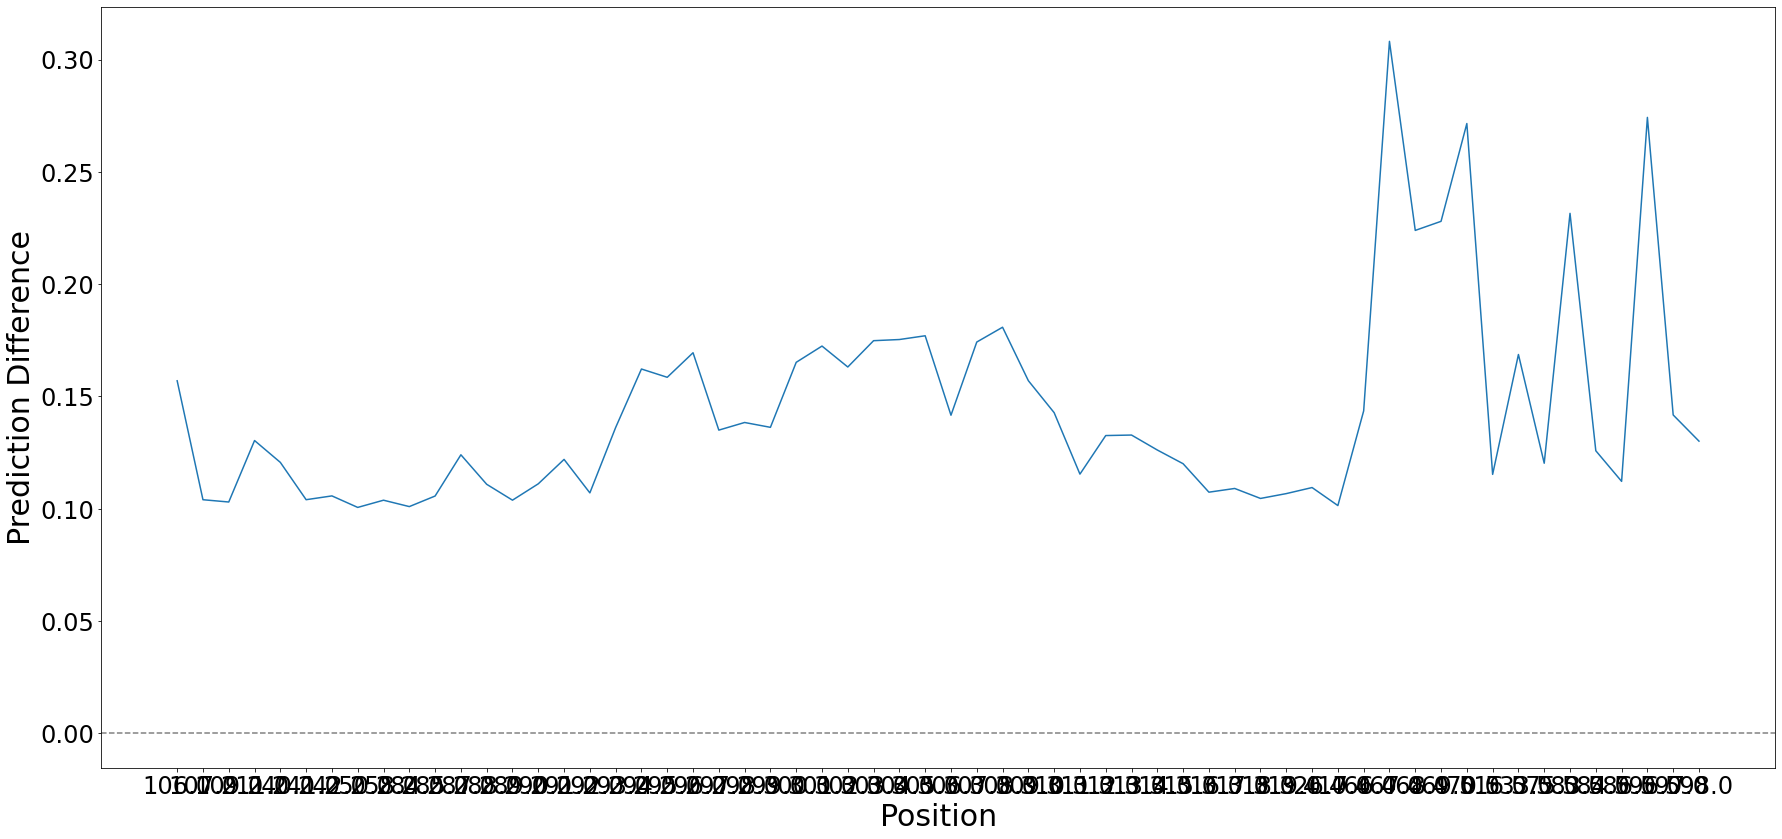

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()